# Hurricane Damage Detector

### Introduction

This project develops a deep learning-based image classifier to detect damaged buildings from satellite images taken after Hurricane Harvey (2017). Using Convolutional Neural Networks (CNNs), the goal is to classify images into damaged vs. non-damaged buildings, aiding in rapid disaster assessment.

### Dataset

The dataset has been taken from IEEE Dataport and modified to build a balanced dataset of satellite images which either signify the present of damaged buildings or buildings with no damage.

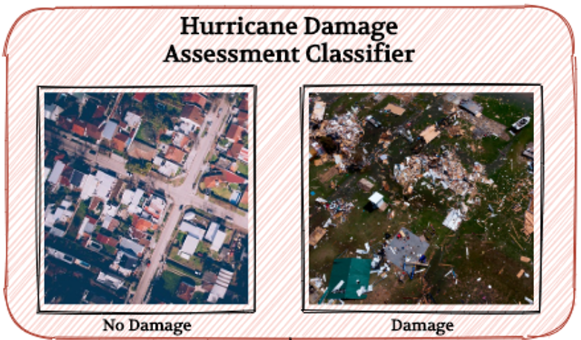

### Key features
- Binary classification of damaged vs. non-damaged buildings.
- Data augmentation to enhance model robustness.
- Transfer learning with VGG16 and ResNet-50 for higher accuracy.
- Comparative analysis of different CNN architectures.

In [ ]:
__author__ = "Bing Huang"
__email__ = "Binghuang1990@gmail.com"

## Load Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.17.0


# 0.Utility functions to create dataset generators

## 0.1 Get train and validation datasets

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds


In [ ]:
# get traina nd validation dataste by calling the function
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


## 0.2 Check Balance in Train data

In [ ]:
import numpy as np
from collections import Counter

train_labels = []

for images, labels in train_ds:
    train_labels.extend(labels.numpy())  # Convert TensorFlow tensors to NumPy array

train_label_counts = Counter(train_labels)  # Count occurrences of each label
print("Training dataset class balance:", train_label_counts)

val_labels = []

for images, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = Counter(val_labels)
print("Validation dataset class balance:", val_label_counts)

Training dataset class balance: Counter({0: 569, 1: 518})
Validation dataset class balance: Counter({1: 137, 0: 134})


## 0.3 Check images in train data

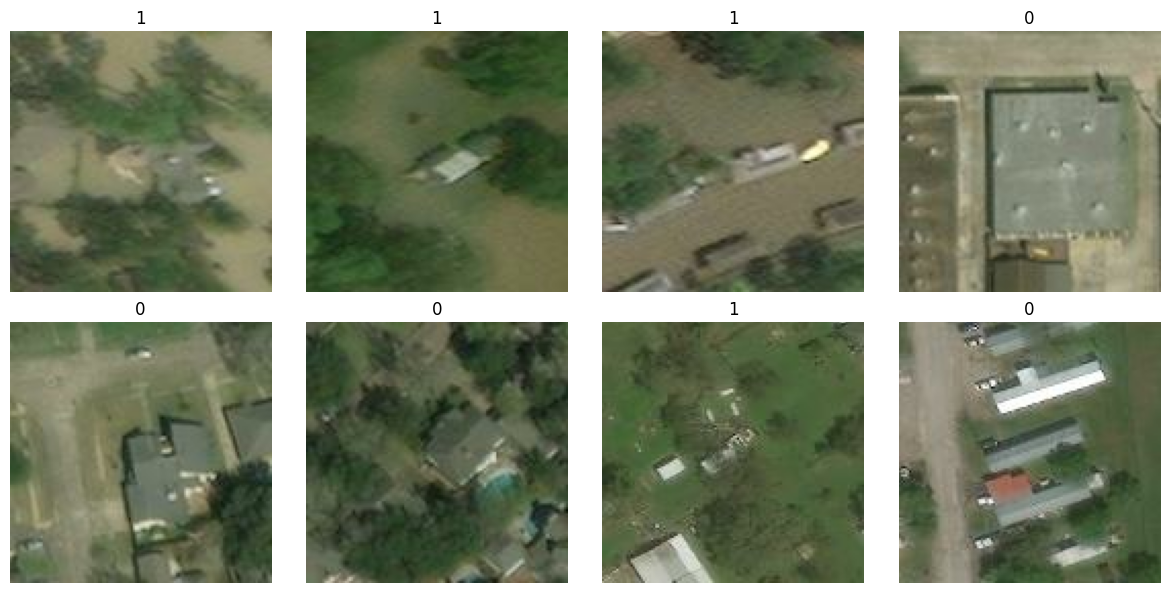

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## 0.4 Define Test and prediction function

In [ ]:
# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# 1.Baseline  Model

Build a basic CNN model from scratch (2-3) layers which should serve as a baseline model and give you around close to 80%+ accuracy easily

In [ ]:
# check image size

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


## 1.1 Build, compile and train the model

In [ ]:
import tensorflow as tf


model1 = tf.keras.Sequential([
          tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
          tf.keras.layers.MaxPooling2D(2, 2),

          tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2, 2),

          tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2, 2),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,634,529 (6.24 MB)

 Trainable params: 1,634,529 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history1 = model1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 781ms/step - accuracy: 0.4868 - loss: 39.7158 - val_accuracy: 0.5646 - val_loss: 0.6590
Epoch 2/10
20/34 ━━━━━━━━━━━━━━━━━━━━ 10s 718ms/step - accuracy: 0.6162 - loss: 0.6282

KeyboardInterrupt: 

## 1.2 Validation result

In [ ]:
# use evaluate function

model1_val_loss, model1_val_accuracy = model1.evaluate(val_ds)

print(f"Validation Loss: {model1_val_loss:.2f}")
print(f"Validation Accuracy: {model1_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8541 - loss: 0.5711
Validation Loss: 0.48
Validation Accuracy: 0.87


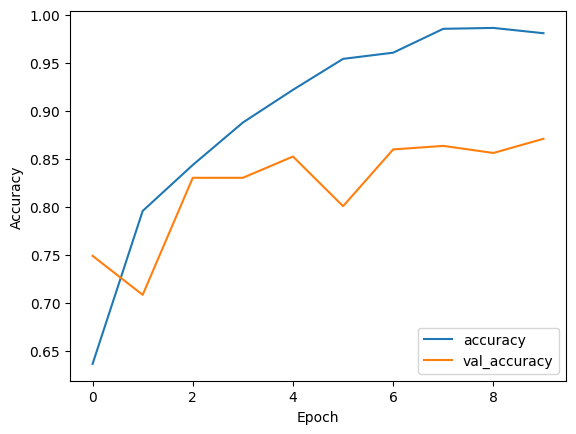

In [ ]:

plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## 1.3 Test Data Results

In [ ]:
test_labels1, predictions1 = eval_model_on_test(model1)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:32,  2.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:27,  3.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:24,  3.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:24,  3.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:23,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:23,  3.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:23,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:22,  3.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:23,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:23,  3.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:03<00:24,  3.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:23,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:22,  3.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:22,  3.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:04<00:21,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:04<00:20,  3.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:04<00:20,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:20,  3.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:05<00:20,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:05<00:20,  3.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:05<00:20,  3.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:05<00:20,  3.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:06<00:20,  3.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:06<00:19,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:06<00:19,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:07<00:19,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:07<00:18,  3.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:07<00:18,  3.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:07<00:18,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:08<00:18,  3.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:08<00:17,  3.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:08<00:17,  3.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:08<00:17,  3.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:09<00:16,  3.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:09<00:16,  3.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:09<00:16,  3.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:10<00:15,  3.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:10<00:15,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:10<00:14,  3.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:10<00:14,  3.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:11<00:14,  3.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:11<00:13,  3.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:11<00:13,  3.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:11<00:13,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:12<00:13,  3.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:12<00:13,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:12<00:13,  3.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:12<00:13,  3.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:13<00:13,  3.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:13<00:12,  3.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:13<00:12,  3.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:14<00:12,  3.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:14<00:12,  3.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:14<00:12,  3.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:15<00:12,  3.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:15<00:11,  3.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:15<00:11,  3.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:15<00:10,  3.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:16<00:10,  3.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:16<00:10,  3.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:16<00:09,  3.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:09,  3.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:17<00:08,  3.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:17<00:08,  3.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:17<00:08,  3.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:08,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:18<00:07,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:18<00:07,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:18<00:07,  3.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:19<00:06,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:19<00:06,  3.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:19<00:06,  3.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:19<00:06,  3.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:20<00:05,  3.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:20<00:05,  3.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:20<00:05,  3.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:20<00:05,  3.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:21<00:04,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:21<00:04,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:21<00:04,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:22<00:03,  3.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:22<00:03,  3.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:22<00:03,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  3.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:23<00:02,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:23<00:02,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  3.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  3.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:24<00:01,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:24<00:01,  3.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  3.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  3.57it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:26<00:00,  3.69it/s]


In [ ]:
from sklearn.metrics import classification_report

predictions_binary1 = np.where(predictions1 > 0.5, 1, 0)

print(classification_report(y_true=test_labels1,
                            y_pred=predictions_binary1,
                            target_names=classes
))

              precision    recall  f1-score   support

   no_damage       0.88      0.85      0.86      6333
      damage       0.85      0.87      0.86      5895

    accuracy                           0.86     12228
   macro avg       0.86      0.86      0.86     12228
weighted avg       0.86      0.86      0.86     12228



In [ ]:
from sklearn.metrics import confusion_matrix
# Convert predictions to class labels
predicted_labels1 = (predictions1 > 0.5).astype(int)
# Get true class labels from validation data
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels1)

# 2.Data Augmentation

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [ ]:
# define the augumentation function:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)   # Randomly flips horizontally (left to right) with a 50% chance.
   #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)   # Randomly changes the brightness of the image
    image = tf.image.random_contrast(image, lower=1, upper=1.5)  # Randomly adjusts the contrast of the image.
    return image, label

In [ ]:
#  use map to apply the augment_image function to train_data
train_ds_a = (train_ds.map(augment_image).shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE))


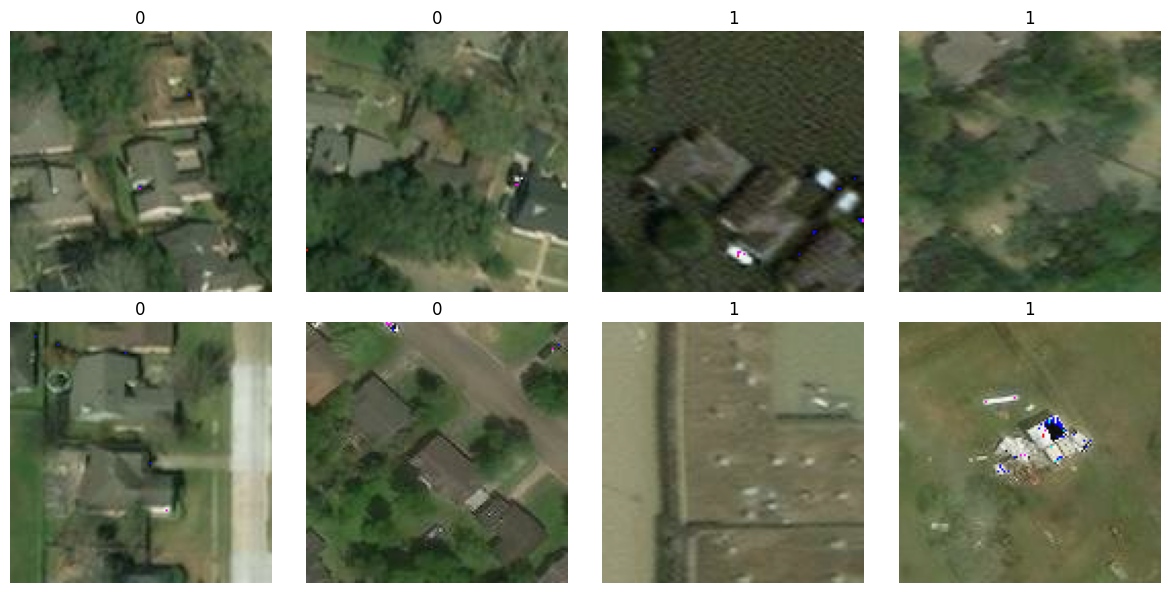

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds_a.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [ ]:
for image_batch, labels_batch in train_ds_a:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


## 2.1 Train Model1 on New data

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history2 = model1.fit(train_ds_a,
                      validation_data=val_ds,
                      epochs=20)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 719ms/step - accuracy: 0.6204 - loss: 0.8761 - val_accuracy: 0.7380 - val_loss: 0.6535
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 743ms/step - accuracy: 0.6753 - loss: 0.6287 - val_accuracy: 0.6568 - val_loss: 0.6515
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 776ms/step - accuracy: 0.7187 - loss: 0.6842 - val_accuracy: 0.6642 - val_loss: 0.6319
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 748ms/step - accuracy: 0.7003 - loss: 0.6195 - val_accuracy: 0.5240 - val_loss: 0.7112
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 752ms/step - accuracy: 0.5964 - loss: 0.6695 - val_accuracy: 0.7159 - val_loss: 0.6233
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 766ms/step - accuracy: 0.6983 - loss: 0.5881 - val_accuracy: 0.5793 - val_loss: 0.6768
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.7003 - loss: 0.6058 - val_accuracy: 0.5646 - val_loss: 0.7039
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 770ms/step - accuracy: 0.6919 - loss: 0.6533 - val_accu

In [ ]:
# use evaluate function

model1_val_loss, model1_val_accuracy = model1.evaluate(val_ds)

print(f"Validation Loss: {model1_val_loss:.2f}")
print(f"Validation Accuracy: {model1_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7234 - loss: 0.8631
Validation Loss: 0.77
Validation Accuracy: 0.73


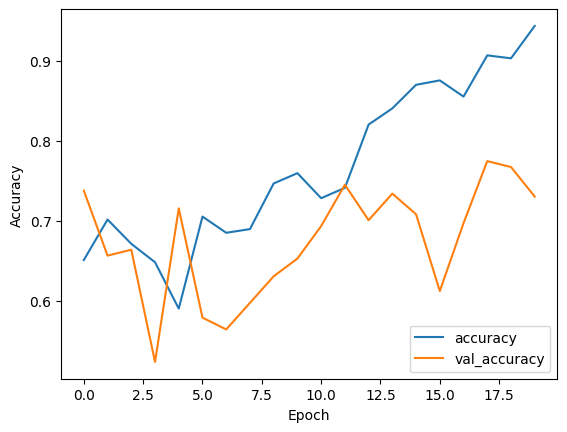

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## 2.2 Test data results

In [ ]:
test_labels, predictions = eval_model_on_test(model1)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:12,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<02:10,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:04<02:08,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:05<02:06,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:06<02:05,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:08<02:04,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:09<02:03,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:10<01:47,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:11<01:50,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:14<02:27,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:16<02:17,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:17<02:09,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:18<01:50,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:19<01:38,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:20<01:41,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:21<01:30,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:22<01:23,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:23<01:18,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:24<01:26,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:27<02:00,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:28<01:54,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:29<01:38,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:30<01:37,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:32<01:37,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:33<01:25,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:34<01:28,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:35<01:29,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:37<01:30,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:39<01:57,  1.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:41<01:48,  1.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:42<01:31,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:43<01:20,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:44<01:21,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:45<01:12,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:46<01:14,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:48<01:16,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:49<01:17,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:52<01:40,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:53<01:33,  1.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:55<01:27,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:56<01:23,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:57<01:19,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:59<01:16,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [01:00<01:14,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [01:01<01:12,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [01:04<01:29,  1.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [01:06<01:22,  1.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  50%|█████     | 48/96 [01:07<01:16,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Predicting on Test Data:  51%|█████     | 49/96 [01:08<01:12,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [01:10<01:08,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [01:11<01:05,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [01:12<00:56,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [01:13<00:56,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [01:15<00:56,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [01:16<00:56,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [01:19<01:11,  1.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [01:20<01:05,  1.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Predicting on Test Data:  60%|██████    | 58/96 [01:22<01:00,  1.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [01:23<00:56,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [01:24<00:48,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [01:25<00:42,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [01:26<00:43,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [01:27<00:38,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [01:29<00:39,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [01:30<00:39,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [01:32<00:40,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [01:33<00:39,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Predicting on Test Data:  71%|███████   | 68/96 [01:34<00:38,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [01:36<00:37,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [01:37<00:35,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [01:39<00:34,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [01:40<00:33,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [01:41<00:31,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [01:43<00:30,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [01:45<00:37,  1.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [01:46<00:30,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  80%|████████  | 77/96 [01:48<00:27,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [01:49<00:23,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [01:50<00:22,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [01:51<00:19,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [01:52<00:18,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [01:53<00:15,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [01:54<00:15,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [01:56<00:14,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [01:59<00:18,  1.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [01:59<00:14,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [02:01<00:12,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [02:02<00:11,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [02:04<00:09,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [02:05<00:08,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [02:06<00:06,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [02:07<00:04,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [02:09<00:03,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [02:11<00:03,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [02:13<00:01,  1.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Predicting on Test Data: 100%|██████████| 96/96 [02:13<00:00,  1.40s/it]


In [ ]:
from sklearn.metrics import classification_report

predictions_binary = np.where(predictions > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=classes
))

              precision    recall  f1-score   support

   no_damage       0.80      0.56      0.66      6333
      damage       0.64      0.85      0.73      5895

    accuracy                           0.70     12228
   macro avg       0.72      0.71      0.70     12228
weighted avg       0.73      0.70      0.70     12228



# 3.Pre-trained Model- VGG16 Model

- deep convolutional neural networks (CNNs) developed by the Visual Geometry Group at the University of Oxford.

- It has 16 weight layers (13 convolutional and 3 fully connected layers)

- Feature extraction

 Pretrained models are typically trained on large datasets like ImageNet and learn to extract meaningful patterns (or features) from your images, such as edges, textures, and shapes


## 3.1 Build, compile, and train the model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

In [ ]:
# Load pre-trained VGG16 model without top (no dense layers)
model_name = 'VGG16'

# Load VGG16 without fully connected layers (include_top=False)
model_base = VGG16(weights='imagenet',
                  include_top=False,  # We don't want the final dense layers
                  input_shape=(128, 128, 3))  # 3 RGB images: 3 channels (Red, Green, Blue)

model_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# free base model (use pretrained weights)
for layer in model_base.layers:
    layer.trainable = False

# Add custom layers
# 1 hidden layer,
# dropout: random 20% of the input units of hidden layers to 0

x = layers.Flatten()(model_base.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model_VGG = models.Model(inputs=model_base.input, outputs=x)


In [ ]:

#### Create the convolutional base model
conv_model = Model(inputs=model_base.input,
                   outputs= model_base.output)

# Freeze all layers of the convolutional base
# want to use the trained weights in VGG
for layer in conv_model.layers:
    layer.trainable = False

# creat my final model
model_VGG = Sequential()

# Add the VGG model
model_VGG.add(conv_model)

# Add custom layers
model_VGG.add(tf.keras.layers.Flatten())
model_VGG.add(tf.keras.layers.Dense(1024, activation='relu'))
model_VGG.add(tf.keras.layers.Dropout(0.2))
model_VGG.add(tf.keras.layers.Dense(1, activation='sigmoid'))

 Custom layer

- Flatten() converts the multi-dimensional output of the base model into a one-dimensional vector, which can then be used as input to fully connected layers.

- Dense Layer (1024 units):
A fully connected layer with 1024 neurons is added, with the ReLU activation function to introduce non-linearity.

- Dropout Layer (0.2):  a regularization technique. Dropout(0.2) is added to prevent overfitting. During training, 20% of the neurons in this layer will randomly be "dropped out" to help the model generalize better.

- Output Layer (1 unit)

My final model is using:

- the pre-trained base model (with its frozen layers) to extract features from images,

- the custom layers learn to classify the images based on those features.

- The final layer with a sigmoid activation function is appropriate for a binary classification task.



In [ ]:
model_VGG.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_3 = model_VGG.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 381s 11s/step - accuracy: 0.7677 - loss: 8.7343 - val_accuracy: 0.8782 - val_loss: 0.8959
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 292s 9s/step - accuracy: 0.9632 - loss: 0.1413 - val_accuracy: 0.9041 - val_loss: 0.5008
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.9833 - loss: 0.0441 - val_accuracy: 0.9188 - val_loss: 0.5208
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.9958 - loss: 0.0105 - val_accuracy: 0.9041 - val_loss: 0.6017
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 314s 8s/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9077 - val_loss: 0.6155
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9077 - val_loss: 0.6315
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.8819 - val_loss: 0.6461
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9987 - loss: 0.0018 - val_accuracy: 0.9151 - 

In [ ]:
#model_VGG.save('model_VGG.h5')
model_VGG.save('model_VGG.keras')

In [ ]:

model1_val_loss, model1_val_accuracy = model_VGG.evaluate(val_ds)

print(f"Validation Loss: {model1_val_loss:.2f}")
print(f"Validation Accuracy: {model1_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.8973 - loss: 0.7604
Validation Loss: 0.70
Validation Accuracy: 0.91


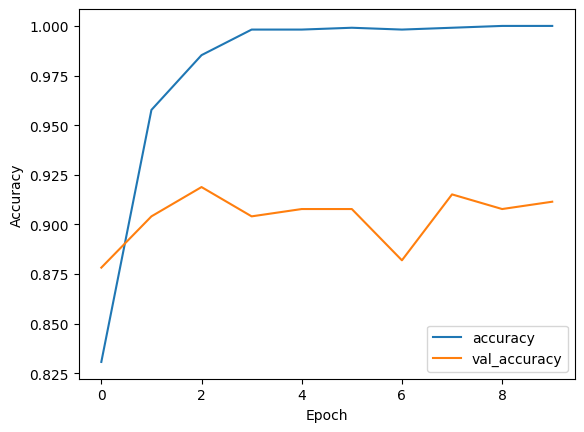

In [ ]:
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## 3.2 Test data results

In [ ]:
test_labels, predictions = eval_model_on_test(model_VGG)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:   1%|          | 1/96 [00:41<1:05:14, 41.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:   2%|▏         | 2/96 [01:22<1:04:25, 41.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:   3%|▎         | 3/96 [01:48<53:14, 34.35s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:   4%|▍         | 4/96 [02:29<56:47, 37.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:   5%|▌         | 5/96 [03:10<58:22, 38.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:   6%|▋         | 6/96 [03:51<59:03, 39.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:   7%|▋         | 7/96 [04:32<59:14, 39.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:   8%|▊         | 8/96 [05:14<59:06, 40.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:   9%|▉         | 9/96 [05:55<58:47, 40.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  10%|█         | 10/96 [06:36<58:21, 40.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  11%|█▏        | 11/96 [07:17<57:50, 40.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  12%|█▎        | 12/96 [07:43<51:03, 36.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  14%|█▎        | 13/96 [08:24<52:24, 37.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


Predicting on Test Data:  15%|█▍        | 14/96 [09:06<53:05, 38.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  16%|█▌        | 15/96 [09:47<53:21, 39.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  17%|█▋        | 16/96 [10:28<53:18, 39.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  18%|█▊        | 17/96 [10:54<47:09, 35.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  19%|█▉        | 18/96 [11:35<48:39, 37.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  20%|█▉        | 19/96 [12:16<49:26, 38.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  21%|██        | 20/96 [12:57<49:46, 39.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  22%|██▏       | 21/96 [13:24<44:24, 35.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  23%|██▎       | 22/96 [14:05<45:55, 37.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  24%|██▍       | 23/96 [14:31<41:17, 33.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  25%|██▌       | 24/96 [14:57<37:38, 31.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


Predicting on Test Data:  26%|██▌       | 25/96 [15:38<40:33, 34.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  27%|██▋       | 26/96 [16:19<42:22, 36.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


Predicting on Test Data:  28%|██▊       | 27/96 [16:46<38:28, 33.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  29%|██▉       | 28/96 [17:27<40:30, 35.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  30%|███       | 29/96 [17:53<36:51, 33.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  31%|███▏      | 30/96 [18:34<38:58, 35.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  32%|███▏      | 31/96 [19:16<40:13, 37.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  33%|███▎      | 32/96 [19:57<40:52, 38.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  34%|███▍      | 33/96 [20:23<36:28, 34.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


Predicting on Test Data:  35%|███▌      | 34/96 [21:04<37:53, 36.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  36%|███▋      | 35/96 [21:45<38:37, 37.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  38%|███▊      | 36/96 [22:26<38:55, 38.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  39%|███▊      | 37/96 [22:52<34:28, 35.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  40%|███▉      | 38/96 [23:34<35:39, 36.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  41%|████      | 39/96 [24:15<36:14, 38.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  42%|████▏     | 40/96 [24:56<36:25, 39.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  43%|████▎     | 41/96 [25:22<32:14, 35.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  44%|████▍     | 42/96 [25:47<28:51, 32.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  45%|████▍     | 43/96 [26:28<30:42, 34.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  46%|████▌     | 44/96 [27:09<31:46, 36.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  47%|████▋     | 45/96 [27:50<32:17, 37.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  48%|████▊     | 46/96 [28:17<28:48, 34.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  49%|████▉     | 47/96 [28:58<29:49, 36.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  50%|█████     | 48/96 [29:24<26:49, 33.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


Predicting on Test Data:  51%|█████     | 49/96 [29:50<24:23, 31.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  52%|█████▏    | 50/96 [30:15<22:34, 29.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


Predicting on Test Data:  53%|█████▎    | 51/96 [30:42<21:32, 28.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  54%|█████▍    | 52/96 [31:10<20:45, 28.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  55%|█████▌    | 53/96 [31:37<20:03, 27.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  56%|█████▋    | 54/96 [32:18<22:20, 31.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  57%|█████▋    | 55/96 [32:59<23:41, 34.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  58%|█████▊    | 56/96 [33:25<21:24, 32.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  59%|█████▉    | 57/96 [33:50<19:31, 30.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  60%|██████    | 58/96 [34:32<21:07, 33.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step


Predicting on Test Data:  61%|██████▏   | 59/96 [35:13<22:00, 35.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


Predicting on Test Data:  62%|██████▎   | 60/96 [35:54<22:23, 37.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  64%|██████▎   | 61/96 [36:35<22:25, 38.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  65%|██████▍   | 62/96 [37:01<19:46, 34.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  66%|██████▌   | 63/96 [37:28<17:51, 32.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  67%|██████▋   | 64/96 [38:09<18:41, 35.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  68%|██████▊   | 65/96 [38:36<16:44, 32.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  69%|██████▉   | 66/96 [39:00<15:04, 30.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  70%|██████▉   | 67/96 [39:27<14:00, 28.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step


Predicting on Test Data:  71%|███████   | 68/96 [40:08<15:12, 32.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  72%|███████▏  | 69/96 [40:34<13:52, 30.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  73%|███████▎  | 70/96 [40:59<12:36, 29.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  74%|███████▍  | 71/96 [41:41<13:37, 32.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  75%|███████▌  | 72/96 [42:22<14:05, 35.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


Predicting on Test Data:  76%|███████▌  | 73/96 [42:48<12:26, 32.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


Predicting on Test Data:  77%|███████▋  | 74/96 [43:14<11:15, 30.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  78%|███████▊  | 75/96 [43:55<11:50, 33.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  79%|███████▉  | 76/96 [44:36<11:59, 36.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  80%|████████  | 77/96 [45:18<11:52, 37.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  81%|████████▏ | 78/96 [45:59<11:34, 38.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  82%|████████▏ | 79/96 [46:25<09:54, 34.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


Predicting on Test Data:  83%|████████▎ | 80/96 [47:06<09:48, 36.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  84%|████████▍ | 81/96 [47:47<09:31, 38.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  85%|████████▌ | 82/96 [48:14<08:04, 34.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  86%|████████▋ | 83/96 [48:55<07:55, 36.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  88%|████████▊ | 84/96 [49:36<07:34, 37.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  89%|████████▊ | 85/96 [50:17<07:07, 38.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


Predicting on Test Data:  90%|████████▉ | 86/96 [50:58<06:35, 39.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  91%|█████████ | 87/96 [51:24<05:18, 35.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  92%|█████████▏| 88/96 [52:05<04:57, 37.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


Predicting on Test Data:  93%|█████████▎| 89/96 [52:46<04:28, 38.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  94%|█████████▍| 90/96 [53:13<03:28, 34.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  95%|█████████▍| 91/96 [53:54<03:03, 36.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  96%|█████████▌| 92/96 [54:35<02:31, 37.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step


Predicting on Test Data:  97%|█████████▋| 93/96 [55:16<01:56, 38.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


Predicting on Test Data:  98%|█████████▊| 94/96 [55:41<01:09, 34.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Predicting on Test Data:  99%|█████████▉| 95/96 [56:22<00:36, 36.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


Predicting on Test Data: 100%|██████████| 96/96 [57:21<00:00, 35.85s/it]


In [ ]:
predictions_binary = np.where(predictions > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=classes
))

              precision    recall  f1-score   support

   no_damage       0.90      0.93      0.92      6333
      damage       0.92      0.89      0.91      5895

    accuracy                           0.91     12228
   macro avg       0.91      0.91      0.91     12228
weighted avg       0.91      0.91      0.91     12228



# 4.ResNet 50 Model

## 4.1 Creat Base model

In [ ]:
model_name = 'resnet50_1'

model_resnet50 = tf.keras.applications.resnet50.ResNet50(input_shape=(128,128,3),
                                                include_top=False,
                                                weights='imagenet',
                                                )
model_resnet50

<Functional name=resnet50, built=True>

In [ ]:
for layer in model_resnet50.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


## 4.2 Create your own model

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
last_conv_layer = model_resnet50.get_layer('conv5_block3_out')

# Create a model with inputs and outputs for the last convolutional layer.
conv_model = Model(inputs=model_resnet50.input,
                   outputs=last_conv_layer.output)

# Freeze all layers of the convolutional base
# want to use the trained weights in resnet
for layer in conv_model.layers:
    layer.trainable = False

# creat a final model
model_resnet50_mine = Sequential()

# Add the convolutional part of the model from above.
model_resnet50_mine.add(conv_model)

# custom layers
model_resnet50_mine.add(layers.GlobalAveragePooling2D())
model_resnet50_mine.add(layers.Dense(512, activation='relu'))
model_resnet50_mine.add(layers.BatchNormalization())
model_resnet50_mine.add(layers.Dropout(0.2))
model_resnet50_mine.add(layers.Dense(128, activation='relu'))
model_resnet50_mine.add(layers.Dropout(0.2))
model_resnet50_mine.add(layers.Dense(1, activation='sigmoid'))

ValueError: Undefined shapes are not supported.

## 4.3 compile and train the model

In [ ]:
model_resnet50_mine.compile(optimizer=Adam(learning_rate=1e-3),
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=['accuracy'])

In [ ]:

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)

history4 = model_resnet50_mine.fit(train_ds,
                                  batch_size=32,
                                  epochs=10,
                                  validation_data=val_ds,
                                  callbacks=[early_stopping_cb],
                                  verbose=1)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8152 - loss: 0.4020 - val_accuracy: 0.9041 - val_loss: 0.2129
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9458 - loss: 0.1469 - val_accuracy: 0.9004 - val_loss: 0.2166
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9871 - loss: 0.0526 - val_accuracy: 0.9336 - val_loss: 0.1598
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9943 - loss: 0.0249 - val_accuracy: 0.9557 - val_loss: 0.1309
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9974 - loss: 0.0175 - val_accuracy: 0.9594 - val_loss: 0.1393
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9936 - loss: 0.0194 - val_accuracy: 0.9557 - val_loss: 0.1390
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9996 - loss: 0.0088 - val_accuracy: 0.9299 - val_loss: 0.2033
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 0.9446 - v

## 4.4 Validation data results

In [ ]:
model4_val_loss, model4_val_accuracy = model_resnet50_mine.evaluate(val_ds)

print(f"Validation Loss: {model4_val_loss:.2f}")
print(f"Validation Accuracy: {model4_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9441 - loss: 0.1668
Validation Loss: 0.13
Validation Accuracy: 0.96


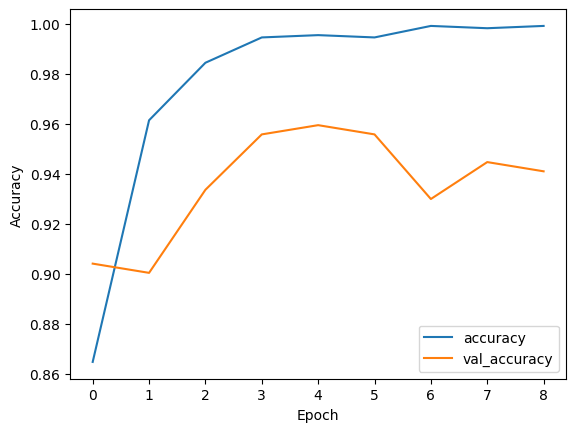

In [ ]:
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## 4.5 Test data results

In [ ]:
test_labels_resnet, predictions_restnet = eval_model_on_test(model_resnet50_mine)

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


Predicting on Test Data:   1%|          | 1/96 [00:20<32:53, 20.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


Predicting on Test Data:   2%|▏         | 2/96 [00:41<32:29, 20.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


Predicting on Test Data:   3%|▎         | 3/96 [01:02<32:02, 20.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:   4%|▍         | 4/96 [01:10<24:31, 16.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:   5%|▌         | 5/96 [01:21<21:10, 13.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:   6%|▋         | 6/96 [01:31<19:07, 12.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:   7%|▋         | 7/96 [01:38<16:10, 10.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:   8%|▊         | 8/96 [01:47<15:02, 10.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:   9%|▉         | 9/96 [01:57<14:55, 10.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  10%|█         | 10/96 [02:05<13:41,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


Predicting on Test Data:  11%|█▏        | 11/96 [02:16<13:53,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  12%|█▎        | 12/96 [02:23<12:46,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  14%|█▎        | 13/96 [02:32<12:28,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  15%|█▍        | 14/96 [02:42<12:52,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  16%|█▌        | 15/96 [02:49<11:43,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  17%|█▋        | 16/96 [02:58<11:41,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  18%|█▊        | 17/96 [03:05<10:49,  8.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  19%|█▉        | 18/96 [03:16<11:30,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  20%|█▉        | 19/96 [03:26<11:56,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  21%|██        | 20/96 [03:33<10:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  22%|██▏       | 21/96 [03:42<10:47,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  23%|██▎       | 22/96 [03:49<10:00,  8.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  24%|██▍       | 23/96 [03:57<10:08,  8.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  25%|██▌       | 24/96 [04:05<09:39,  8.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  26%|██▌       | 25/96 [04:15<10:21,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  27%|██▋       | 26/96 [04:26<10:46,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  28%|██▊       | 27/96 [04:36<11:00,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  29%|██▉       | 28/96 [04:43<09:57,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  30%|███       | 29/96 [04:52<09:46,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  31%|███▏      | 30/96 [04:58<09:01,  8.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  32%|███▏      | 31/96 [05:07<09:03,  8.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  33%|███▎      | 32/96 [05:18<09:33,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  34%|███▍      | 33/96 [05:28<09:51,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  35%|███▌      | 34/96 [05:38<10:00,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  36%|███▋      | 35/96 [05:49<10:03,  9.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  38%|███▊      | 36/96 [05:59<10:01, 10.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  39%|███▊      | 37/96 [06:09<09:57, 10.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  40%|███▉      | 38/96 [06:16<08:51,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  41%|████      | 39/96 [06:27<09:02,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  42%|████▏     | 40/96 [06:34<08:08,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


Predicting on Test Data:  43%|████▎     | 41/96 [06:54<11:16, 12.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  44%|████▍     | 42/96 [07:05<10:32, 11.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  45%|████▍     | 43/96 [07:15<09:59, 11.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  46%|████▌     | 44/96 [07:25<09:34, 11.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  47%|████▋     | 45/96 [07:36<09:13, 10.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  48%|████▊     | 46/96 [07:44<08:29, 10.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  49%|████▉     | 47/96 [07:51<07:31,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  50%|█████     | 48/96 [08:00<07:18,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


Predicting on Test Data:  51%|█████     | 49/96 [08:10<07:15,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


Predicting on Test Data:  52%|█████▏    | 50/96 [08:23<07:57, 10.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  53%|█████▎    | 51/96 [08:33<07:46, 10.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  54%|█████▍    | 52/96 [08:42<07:10,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


Predicting on Test Data:  55%|█████▌    | 53/96 [08:52<07:09, 10.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  56%|█████▋    | 54/96 [09:01<06:51,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  57%|█████▋    | 55/96 [09:09<06:15,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


Predicting on Test Data:  58%|█████▊    | 56/96 [09:19<06:21,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


Predicting on Test Data:  59%|█████▉    | 57/96 [09:36<07:35, 11.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


Predicting on Test Data:  60%|██████    | 58/96 [09:49<07:30, 11.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  61%|██████▏   | 59/96 [09:59<07:02, 11.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  62%|██████▎   | 60/96 [10:09<06:39, 11.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  64%|██████▎   | 61/96 [10:16<05:44,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  65%|██████▍   | 62/96 [10:26<05:39, 10.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  66%|██████▌   | 63/96 [10:34<05:05,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  67%|██████▋   | 64/96 [10:42<04:45,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  68%|██████▊   | 65/96 [10:50<04:30,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  69%|██████▉   | 66/96 [11:01<04:36,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  70%|██████▉   | 67/96 [11:10<04:24,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


Predicting on Test Data:  71%|███████   | 68/96 [11:20<04:27,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  72%|███████▏  | 69/96 [11:27<03:56,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  73%|███████▎  | 70/96 [11:36<03:49,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  74%|███████▍  | 71/96 [11:43<03:26,  8.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  75%|███████▌  | 72/96 [11:53<03:33,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  76%|███████▌  | 73/96 [12:04<03:34,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  77%|███████▋  | 74/96 [12:14<03:32,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  78%|███████▊  | 75/96 [12:22<03:13,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  79%|███████▉  | 76/96 [12:31<02:59,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  80%|████████  | 77/96 [12:38<02:42,  8.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  81%|████████▏ | 78/96 [12:47<02:36,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  82%|████████▏ | 79/96 [12:54<02:18,  8.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  83%|████████▎ | 80/96 [13:05<02:20,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  84%|████████▍ | 81/96 [13:12<02:03,  8.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


Predicting on Test Data:  85%|████████▌ | 82/96 [13:32<02:47, 11.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  86%|████████▋ | 83/96 [13:42<02:29, 11.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  88%|████████▊ | 84/96 [13:53<02:13, 11.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  89%|████████▊ | 85/96 [14:03<02:00, 10.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  90%|████████▉ | 86/96 [14:14<01:47, 10.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  91%|█████████ | 87/96 [14:22<01:31, 10.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  92%|█████████▏| 88/96 [14:33<01:21, 10.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  93%|█████████▎| 89/96 [14:41<01:06,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  94%|█████████▍| 90/96 [14:51<00:58,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  95%|█████████▍| 91/96 [15:01<00:49,  9.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  96%|█████████▌| 92/96 [15:08<00:36,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Predicting on Test Data:  97%|█████████▋| 93/96 [15:17<00:26,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Predicting on Test Data:  98%|█████████▊| 94/96 [15:28<00:18,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Predicting on Test Data:  99%|█████████▉| 95/96 [15:35<00:08,  8.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


Predicting on Test Data: 100%|██████████| 96/96 [15:42<00:00,  9.82s/it]


In [ ]:
predictions_binary = np.where(predictions_restnet > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=classes
))

              precision    recall  f1-score   support

   no_damage       0.92      0.97      0.94      6333
      damage       0.97      0.91      0.94      5895

    accuracy                           0.94     12228
   macro avg       0.94      0.94      0.94     12228
weighted avg       0.94      0.94      0.94     12228

